In [115]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
from Preprocess import Preprocess
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional, TimeDistributed, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
import ast

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [6]:
# 학습용 데이터 로드
df = pd.read_csv('../data/수정데이터/sample.csv')
df.head()

,text,nouns,match
0,반갑습니다 소속 상담사 이름입니다,"['반갑습니다', '소속', '상담', '사', '이름']","[('반갑습니다', 'O'), ('소속', 'O'), ('상담', 'O'), ('사..."
1,안내해 주신 방법을 시도해 봤는데 안 돼서요,"['안내', '방법', '시도']","[('안내', 'O'), ('방법', 'O'), ('시도', 'O')]"
2,그러시다면 두 번째 방법은요,"['번', '방법']","[('번', 'O'), ('방법', 'O')]"
3,휴대폰 명의자 본인이요,"['휴대폰', '명의자', '본인']","[('휴대폰', 'O'), ('명의자', 'O'), ('본인', 'O')]"
4,휴대폰하고 신분증 챙기셔서 저희 서비스센터 쪽으로 방문하셔야 되세요 고객님,"['휴대폰', '신분증', '서비스', '센터', '쪽', '방문', '고객']","[('휴대폰', 'O'), ('신분증', 'O'), ('서비스', 'O'), ('센..."


In [143]:
p = Preprocess(word2index_dic='../data/chatbot_dict.bin',
               userdic='../data/user_dic.tsv')

In [144]:
df.isnull().any()

text     False
nouns    False
match    False
dtype: bool

In [145]:
drop_idx = df[df['nouns'] == '[]'].index

In [146]:
df.drop(index=drop_idx, inplace=True)

In [147]:
tagged_sentences = df['match'].map(lambda x: ast.literal_eval(x))

In [148]:
sentence, tag_info = zip(*tagged_sentences[0])

In [149]:
sentence

('반갑습니다', '소속', '상담', '사', '이름')

In [150]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences:
    try:
        sentence, tag_info = zip(*tagged_sentence) 
        sentences.append(list(sentence))
        ner_tags.append(list(tag_info))
    except:
        print(tagged_sentence)

print('샘플 개수:', len(sentences))
print('0번 째 샘플 단어 시퀀스:', sentences[0])
print('0번 째 샘플 bio 태그:', ner_tags[0])
print('샘플 단어 시퀀스 최대 길이:', max(len(l) for l in sentences))
print('샘플 단어 시퀀스 평균 길이:', (sum(map(len, sentences)) / len(sentences)))

샘플 개수: 99
0번 째 샘플 단어 시퀀스: ['반갑습니다', '소속', '상담', '사', '이름']
0번 째 샘플 bio 태그: ['O', 'O', 'O', 'O', 'O']
샘플 단어 시퀀스 최대 길이: 10
샘플 단어 시퀀스 평균 길이: 3.696969696969697


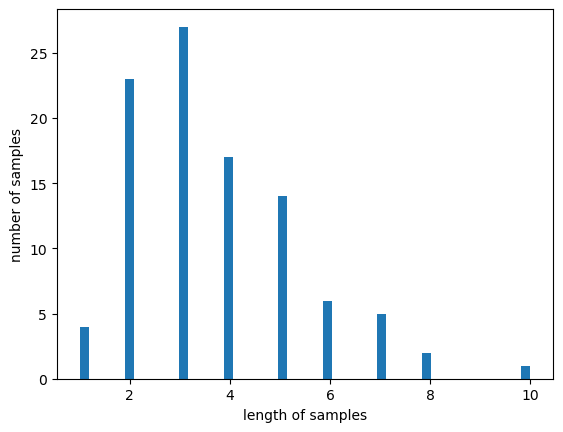

In [151]:
import matplotlib.pyplot as plt
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [152]:
# 말뭉치 데이터에서 단어와 BIO태그만 불러와 학습용 데이터셋 생성
temp = []
for tag in ner_tags:
    temp += tag

In [153]:
# BIO태그별 각각의 값의 개수 카운트
tags = np.array(temp)

tag, cnt = np.unique(tags, return_counts=True)
pd.DataFrame({'ner tag': tag, 'cnt': cnt})

,ner tag,cnt
0,O,366


In [154]:
# 토크나이저 정의
tag_tokenizer = preprocessing.text.Tokenizer(lower=False)
tag_tokenizer.fit_on_texts(ner_tags)

In [155]:
# 단어사전 및 태그 사전 크기
vocab_size = len(p.word_index) + 1
tag_size = len(tag_tokenizer.word_index) + 1
print('BIO 태그 사전 크기:', tag_size)
print('단어 사전 크기:', vocab_size)

BIO 태그 사전 크기: 2
단어 사전 크기: 91132


In [156]:
# 학습용 단어 시퀀스 생성
x_train = [p.get_wordidx_sequence(sent) for sent in sentences]
y_train = tag_tokenizer.texts_to_sequences(ner_tags)
index_to_ner = tag_tokenizer.index_word # 시퀀스 인덱스를 NER로 변환 하기 위해 사용
index_to_ner[0] = 'PAD'

In [138]:
# 시퀀스 패딩 처리
max_len = 30
x_train = preprocessing.sequence.pad_sequences(x_train, padding='post', maxlen=max_len)
y_train = preprocessing.sequence.pad_sequences(y_train, padding='post', maxlen=max_len)

In [139]:
# 학습 데이터와 테스트 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=10)

In [140]:
# 출력 데이터 원핫인코딩
y_train = tf.keras.utils.to_categorical(y_train, num_classes=tag_size)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=tag_size)

print('학습 샘플 시퀀스 형상:', x_train.shape)
print('학습 샘플 레이블 형상:', y_train.shape)
print('테스트 샘플 시퀀스 형상:', x_test.shape)
print('테스트 샘플 레이블 형상:', y_test.shape)

학습 샘플 시퀀스 형상: (79, 30)
학습 샘플 레이블 형상: (79, 30, 2)
테스트 샘플 시퀀스 형상: (20, 30)
테스트 샘플 레이블 형상: (20, 30, 2)


In [142]:
# 모델 정의 (Bi-LSTM)
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True, dropout=0.50, recurrent_dropout=0.25)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, epochs=10)
model.save('./model/ner_model.h5')

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "c:\anaconda\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\anaconda\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\anaconda\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\anaconda\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\anaconda\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\anaconda\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\anaconda\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\anaconda\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\anaconda\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\anaconda\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\anaconda\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "c:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "c:\anaconda\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\tjoeun\AppData\Local\Temp\ipykernel_7264\2746901855.py", line 7, in <module>
      model.fit(x_train, y_train, batch_size=128, epochs=10)
    File "c:\anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\anaconda\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\anaconda\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\anaconda\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\anaconda\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\anaconda\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\anaconda\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "c:\anaconda\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\anaconda\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\anaconda\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\anaconda\lib\site-packages\keras\losses.py", line 2084, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "c:\anaconda\lib\site-packages\keras\backend.py", line 5630, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "c:\anaconda\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\anaconda\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\anaconda\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\anaconda\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\anaconda\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\anaconda\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\anaconda\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\anaconda\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\anaconda\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\anaconda\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\anaconda\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "c:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "c:\anaconda\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\tjoeun\AppData\Local\Temp\ipykernel_7264\2746901855.py", line 7, in <module>
      model.fit(x_train, y_train, batch_size=128, epochs=10)
    File "c:\anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\anaconda\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\anaconda\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\anaconda\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\anaconda\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\anaconda\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\anaconda\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "c:\anaconda\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\anaconda\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\anaconda\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\anaconda\lib\site-packages\keras\losses.py", line 2084, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "c:\anaconda\lib\site-packages\keras\backend.py", line 5630, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  logits and labels must have the same first dimension, got logits shape [2370,2] and labels shape [4740]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]
	 [[broadcast_weights_1/assert_broadcastable/AssertGuard/pivot_f/_1751/_303]]
  (1) INVALID_ARGUMENT:  logits and labels must have the same first dimension, got logits shape [2370,2] and labels shape [4740]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_17147]

In [13]:
# 모델 평가
from tensorflow import keras
model = keras.models.load_model('./model/ner_model.h5')
print('평가 결과:', model.evaluate(x_test, y_test)[1])

377/377 [==============================] - 41s 107ms/step - loss: 0.0033 - accuracy: 0.9930
평가 결과: 0.9929937124252319


In [16]:
# 시퀀스를 NER 태그로 변환하는 함수
def sequences_to_tag(sequences):
    result = []
    for sequence in sequences:
        temp = []
        for pred in sequence:
            pred_index = np.argmax(pred)
            temp.append(index_to_ner[pred_index].replace('PAD', 'O'))
        result.append(temp)
    return result

In [22]:
# f1 스코어
from seqeval.metrics import f1_score, classification_report
y_predicted = model.predict([x_test]) # 테스트 데이터셋의 NER 예측
pred_tags = sequences_to_tag(y_predicted) # 예측된 NER
test_tags = sequences_to_tag(y_test) # 실제 NER
print(classification_report(test_tags, pred_tags))
print('F1-score: {:.1%}'.format(f1_score(test_tags, pred_tags)))

377/377 [==============================] - 41s 109ms/step


c:\Users\user\anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: R seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\user\anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: C seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\user\anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: T seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\user\anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: A seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\user\anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: DT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\user\anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: 

              precision    recall  f1-score   support

           T       0.00      0.00      0.00         9
           _       0.00      0.00      0.00        14

   micro avg       0.00      0.00      0.00        23
   macro avg       0.00      0.00      0.00        23
weighted avg       0.00      0.00      0.00        23

F1-score: 0.0%


In [ ]:
# # 모델 정의
# from keras_crf import CRFModel

# embedding_dim = 128
# hidden_units = 64
# dropout_ratio = 0.3
# adam = Adam(learning_rate=0.001)

# sequence_input = Input(shape=(max_len, ), dtype=tf.int32, name='sequence_input')
# model_embedding = Embedding(input_dim=vocab_size,
#                             output_dim=embedding_dim,
#                             input_length=max_len)(sequence_input)
# model_bilstm = Bidirectional(LSTM(hidden_units, return_sequences=True))
# model_dropout = TimeDistributed(Dropout(dropout_ratio))(model_bilstm)
# model_dense = TimeDistributed(Dense(tag_size, activation='relu'))(model_dropout)
# base = Model(inputs=sequence_input, outputs=model_dense)
# model = CRFModel(base, tag_size)
# model.compile(optimizer=adam, metrics='accuracy')

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# mc = ModelCheckpoint('bilstm_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

# history = model.fit(x_train, y_train.astype(int), batch_size=128, epochs=10, callbacks=[mc, es])